In [1]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv(override=True)

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path: sys.path.insert(0, project_root)

In [2]:
TICKER = 'NVDA'

In [3]:
# create training, val, test datasets

import pandas as pd
df_local_file_path = os.path.join(project_root, 'data', 'df', TICKER, 'df.parquet')
df = pd.read_parquet(df_local_file_path)
df.info()


# create target and input vals
target_col = 'close'
y = df.copy()[target_col].shift(-1) # avoid data leakage
y = y.iloc[:-1] # drop the last row (y = nan)

input_cols = [col for col in df.columns if col not in [target_col, 'dt']] # drop dt as year, month, date can capture sequence
X = df.copy()[input_cols]
X = X.iloc[:-1] # drop the last row

# create trainning and test dataset (trianing will split into train and val for wfv)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=800, shuffle=False, random_state=42)


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = ['year', 'month', 'date']
num_cols = list(set(input_cols) - set(cat_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6501 entries, 0 to 6500
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   dt               6501 non-null   datetime64[ns]
 1   open             6501 non-null   float32       
 2   high             6501 non-null   float32       
 3   low              6501 non-null   float32       
 4   close            6501 non-null   float32       
 5   volume           6501 non-null   int32         
 6   ave_open         6501 non-null   float32       
 7   ave_high         6501 non-null   float32       
 8   ave_low          6501 non-null   float32       
 9   ave_close        6501 non-null   float32       
 10  total_volume     6501 non-null   int32         
 11  30_day_ma_close  6501 non-null   float32       
 12  year             6501 non-null   object        
 13  month            6501 non-null   object        
 14  date             6501 non-null   object 

In [ ]:
# lstm model
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout = dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        o_t, _ = self.lstm(x, (h0.detach(), c0.detach()))
        o_final = self.fc(o_t[:, -1, :])
        return o_final

In [ ]:
# train, cross val funcs
import torch
import torch.nn as nn
import random
from math import log, floor

from src._utils import main_logger


def train_and_val(hyperparams, budget, X_train, y_train, X_val, y_val, patience=10, tol=1e-5):
    # unpack hyperparameters
    lr = hyperparams['lr']
    hidden_dim = hyperparams['hidden_dim']
    layer_dim = hyperparams['layer_dim']
    dropout = hyperparams['dropout']
    batch_size = hyperparams['batch_size']

    # initialize model, loss function, and optimizer
    model = LSTMModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1, dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # training loop for the specified budget
    for epoch in range(int(budget)):
        main_logger.info(f'... start epoch {epoch + 1} ...')
        model.train()
        
        permutation = torch.randperm(X_train.size(0))

        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i : i + batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]
            
            # reshape input to (batch_size, sequence_length, input_dim)
            batch_X = batch_X.unsqueeze(1)
            
            outputs = model(batch_X) 
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # evaluate on validation set at the end of each epoch
        model.eval()
        with torch.inference_mode():
            # reshape validation input to (batch_size, sequence_length, input_dim)
            X_val_reshaped = X_val.unsqueeze(1)
            outputs_val = model(X_val_reshaped)
            
            val_loss = criterion(outputs_val, y_val).item()
            loss_history.append(val_loss)

            # early stopping
            if val_loss + tol < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict() # save the best model state
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    main_logger.info(f'... early stopping at epoch {epoch+1} due to no improvement in validation loss ...')
                    model.load_state_dict(best_model_state) # type: ignore
                    return best_val_loss, loss_history
        
        main_logger.info(f'... epoch {epoch + 1}: loss {val_loss:.4f} ...')

    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return best_val_loss, loss_history


def train_and_val_wfv(hyperparams, budget, X, y, train_window, val_window):
    total_val_loss = 0
    all_loss_histories = []
    
    num_folds = (X.size(0) - train_window - val_window) // val_window + 1
    
    for i in range(num_folds):
        train_start = i * val_window
        train_end = train_start + train_window
        val_start = train_end
        val_end = val_start + val_window
        
        # ensure not to past the last item
        if val_end > X.size(0):
            break
        
        X_train_fold = X[train_start:train_end]
        y_train_fold = y[train_start:train_end]
        X_val_fold = X[val_start:val_end]
        y_val_fold = y[val_start:val_end]
        
        main_logger.info(f'... running Walk-Forward Validation Fold {i+1}/{num_folds}...')
        main_logger.info(f'... training on samples {train_start} to {train_end - 1}')
        main_logger.info(f'... validating on samples {val_start} to {val_end - 1}')
        
        # train and validate on the current fold
        fold_val_loss, fold_loss_history = train_and_val(
            hyperparams=hyperparams,
            budget=budget,
            X_train=X_train_fold,
            y_train=y_train_fold,
            X_val=X_val_fold,
            y_val=y_val_fold
        )
        
        total_val_loss += fold_val_loss
        all_loss_histories.append(fold_loss_history)
        
    avg_val_loss = total_val_loss / num_folds
    
    return avg_val_loss, all_loss_histories


def run_hyperband(search_space_fn, val_fn, R, eta):
    s_max = int(log(R, eta))
    
    overall_best_config = None
    overall_best_loss = float('inf')
    all_loss_histories = []

    # outer loop: Iterate through all brackets
    for s in range(s_max, -1, -1):
        n = int(R / eta**s)
        r = int(R / n)

        main_logger.info(f'... running bracket s={s}: {n} configurations, initial budget={r} ...')
        
        # geerate n random hyperparameter configurations
        configs = [search_space_fn() for _ in range(n)]
        
        # successive halving
        for i in range(s + 1):
            budget = r * (eta**i)
            main_logger.info(f'... training {len(configs)} configurations for budget {budget} epochs ...')
            
            evaluated_results = []
            for config in configs:
                loss, loss_history = val_fn(config, budget)
                evaluated_results.append((config, loss, loss_history))
            
            # record loss histories for plotting
            all_loss_histories.append((evaluated_results, budget))

            # sort and select top configurations
            evaluated_results.sort(key=lambda x: x[1])
            
            # keep track of the best configuration found so far
            if evaluated_results and evaluated_results[0][1] < overall_best_loss:
                overall_best_loss = evaluated_results[0][1]
                overall_best_config = evaluated_results[0][0]
            
            num_to_keep = floor(len(configs) / eta)
            configs = [result[0] for result in evaluated_results[:num_to_keep]]
            
            if not configs:
                break
    
    return overall_best_config, overall_best_loss, all_loss_histories, s_max



# define a search space
def search_space():
    return {
        'lr': 10**random.uniform(-6, -1),
        'hidden_dim': random.choice([16, 32, 64, 128, 256]),
        'layer_dim': random.choice([1, 2, 3, 4, 5]),
        'dropout': random.uniform(0.1, 0.6),
        'batch_size': random.choice([16, 32, 64, 128, 256])
    }


# define budget, halving factor
R = 100
eta = 3

# convert the dense numpy arrays to pytorch tensors
X_train = torch.from_numpy(X_train.toarray()).float() # type: ignore
y_train = torch.from_numpy(y_train.values).float().unsqueeze(1)

X_test = torch.from_numpy(X_test.toarray()).float()  # type: ignore
y_test = torch.from_numpy(y_test.values).float().unsqueeze(1)

# wfv setting
train_window = 3000
val_window = 500

# run sha
best_config, best_loss, all_loss_histories, s_max = run_hyperband(
    search_space_fn=search_space, 
    val_fn=lambda h, b: train_and_val_wfv(h, b, X_train, y_train, train_window=train_window, val_window=val_window),
    R=R, 
    eta=eta
)

main_logger.info(f'... best configuration found: {best_config}\n val loss: {best_loss:.4f} ...')

2025-09-08 01:14:31,208 - root - INFO - ... running bracket s=4: 1 configurations, initial budget=100 ...
2025-09-08 01:14:31,208 - root - INFO - ... training 1 configurations for budget 100 epochs ...
2025-09-08 01:14:31,209 - root - INFO - ... running Walk-Forward Validation Fold 1/5...
2025-09-08 01:14:31,209 - root - INFO - ... training on samples 0 to 2999
2025-09-08 01:14:31,209 - root - INFO - ... validating on samples 3000 to 3499
2025-09-08 01:14:31,795 - root - INFO - ... start epoch 1 ...
2025-09-08 01:14:32,211 - root - INFO - ... epoch 1: loss 0.8011 ...
2025-09-08 01:14:32,211 - root - INFO - ... start epoch 2 ...
2025-09-08 01:14:32,618 - root - INFO - ... epoch 2: loss 0.4635 ...
2025-09-08 01:14:32,619 - root - INFO - ... start epoch 3 ...
2025-09-08 01:14:33,000 - root - INFO - ... epoch 3: loss 0.3352 ...
2025-09-08 01:14:33,000 - root - INFO - ... start epoch 4 ...
2025-09-08 01:14:33,397 - root - INFO - ... epoch 4: loss 0.2824 ...
2025-09-08 01:14:33,397 - root - 

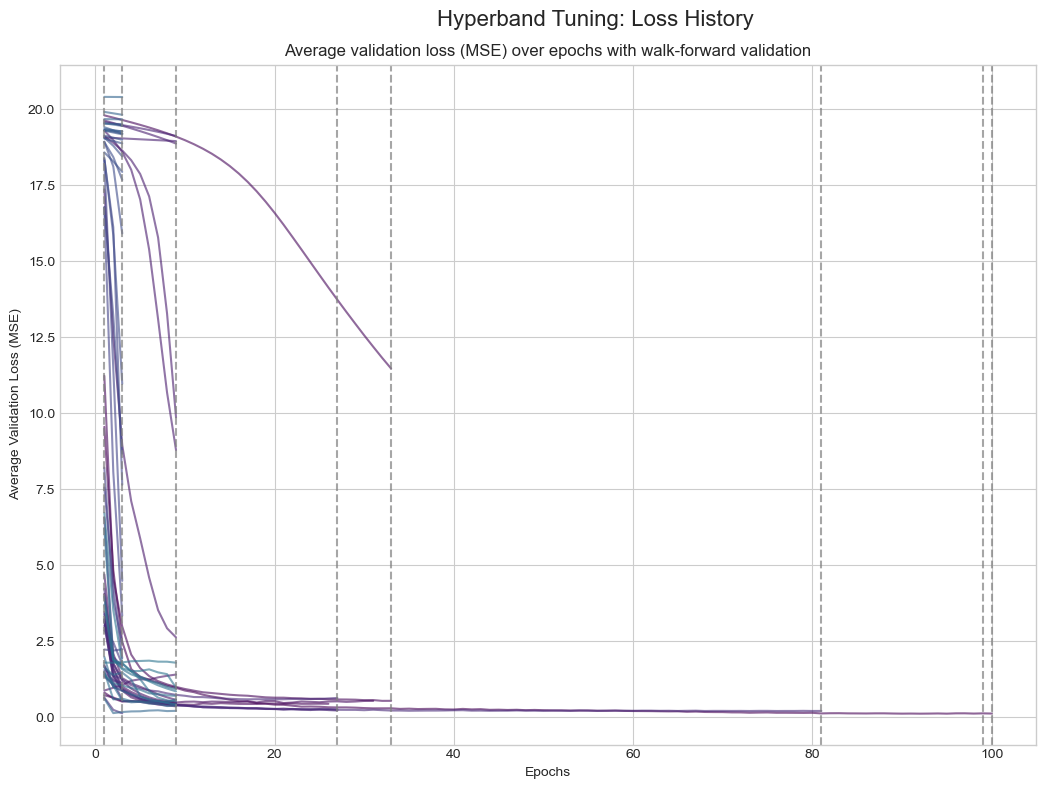

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

all_individual_histories = []
for stage_results, budget in all_loss_histories:
    for config, avg_wfv_loss, list_of_fold_histories in stage_results:
        # check if there are any histories to process
        if list_of_fold_histories and any(h for h in list_of_fold_histories):
            # convert each fold's history to a numpy array for easy averaging
            np_histories = [np.array(h) for h in list_of_fold_histories if h is not None and len(h) > 0]
            
            if np_histories:
                # pad histories to the maximum length if they stopped at different epochs
                max_len = max(len(h) for h in np_histories)
                padded_np_histories = []
                for h in np_histories:
                    # pad with the last value to visualize the plateau if early stopped
                    padded_h = np.pad(h, (0, max_len - len(h)), 'edge')
                    padded_np_histories.append(padded_h)

                # calculate the average history for this specific configuration
                average_history_for_config = np.mean(padded_np_histories, axis=0)
                
                # store the result for plotting
                all_individual_histories.append((budget, average_history_for_config))


colors = plt.cm.viridis(np.linspace(0, 1, len(all_individual_histories))) # type: ignore

for i, (budget, history) in enumerate(all_individual_histories):
    plt.plot(range(1, len(history) + 1), history, color=colors[i], alpha=0.6, label=f'Budget {budget} Trial {i+1}')

plt.title('Average validation loss (MSE) over epochs with walk-forward validation')
plt.xlabel('Epochs')
plt.ylabel('Average Validation Loss (MSE)')
plt.grid(True)
plt.suptitle("Hyperband Tuning: Loss History", fontsize=16)

# add vertical lines on halving stages
budgets_plotted = sorted(list(set([data[0] for data in all_individual_histories])))

for budget_val in budgets_plotted:
    if budget_val > 0:
        plt.axvline(x=budget_val, linestyle='--', color='gray', alpha=0.7)

plt.tight_layout(rect=[0, 0, 0.88, 1]) # type: ignore
plt.show()

In [18]:
# cf. bayesian opt

import optuna

def objective(trial, X, y):
    # same search space as hyperband
    hyperparams = {
        'lr': trial.suggest_float('lr', 1e-6, 1e-1, log=True),
        'hidden_dim': trial.suggest_categorical('hidden_dim', [16, 32, 64, 128, 256]),
        'layer_dim': trial.suggest_int('layer_dim', 1, 5),
        'dropout': trial.suggest_float('dropout', 0.1, 0.6),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    }
    
    # run walk-forward validation with the suggested hyperparameters
    avg_val_loss, _ = train_and_val_wfv(
        hyperparams=hyperparams,
        budget=R,
        X=X,
        y=y,
        train_window=train_window,
        val_window=val_window
    )
    
    # store full history as a user attribute for plotting later
    trial.set_user_attr("all_loss_histories", all_loss_histories)
    return avg_val_loss


main_logger.info('... starting bayesian optimization w/ optuna ...')

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=20)

best_config = study.best_trial.params
best_loss = study.best_trial.value

main_logger.info(f'... best configuration found: {best_config}\n val loss: {best_loss:.4f} ...')

2025-09-08 02:50:40,997 - root - INFO - ... starting bayesian optimization w/ optuna ...
[I 2025-09-08 02:50:40,998] A new study created in memory with name: no-name-6472c2f8-c596-4ca7-a388-9d9ddf0d8af9
2025-09-08 02:50:41,000 - root - INFO - ... running Walk-Forward Validation Fold 1/5...
2025-09-08 02:50:41,000 - root - INFO - ... training on samples 0 to 2999
2025-09-08 02:50:41,001 - root - INFO - ... validating on samples 3000 to 3499
2025-09-08 02:50:41,003 - root - INFO - ... start epoch 1 ...
2025-09-08 02:50:41,088 - root - INFO - ... epoch 1: loss 6.9945 ...
2025-09-08 02:50:41,088 - root - INFO - ... start epoch 2 ...
2025-09-08 02:50:41,165 - root - INFO - ... epoch 2: loss 6.5778 ...
2025-09-08 02:50:41,165 - root - INFO - ... start epoch 3 ...
2025-09-08 02:50:41,242 - root - INFO - ... epoch 3: loss 6.0879 ...
2025-09-08 02:50:41,243 - root - INFO - ... start epoch 4 ...
2025-09-08 02:50:41,322 - root - INFO - ... epoch 4: loss 5.5030 ...
2025-09-08 02:50:41,322 - root -

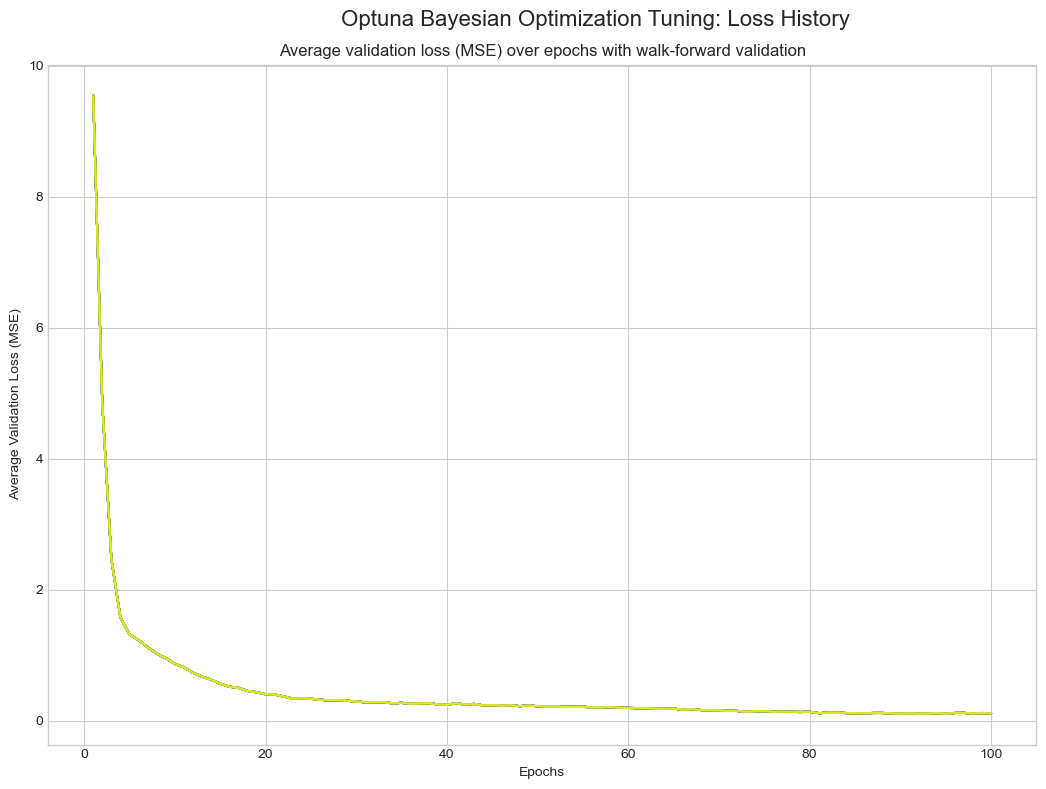

In [50]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

all_histories_b = []

for trial in study.trials:
    try:
        trial_histories = trial.user_attrs["all_loss_histories"][0][0][0][2]
       
        if trial_histories and isinstance(trial_histories, list) and isinstance(trial_histories[0], list):
            max_len = max(len(h) for h in trial_histories)
            padded_histories = [np.pad(h, (0, max_len - len(h)), 'edge') for h in trial_histories]
            
            if padded_histories:
                average_history = np.mean(padded_histories, axis=0)
                all_histories_b.append(average_history)

    except (KeyError, IndexError, TypeError) as e:
        print(f"Skipping trial {trial.number} due to data access error: {e}")
        continue

colors = plt.cm.viridis(np.linspace(0, 1, len(all_histories_b))) # type: ignore


for i, history in enumerate(all_histories_b):
    plt.plot(range(1, len(history) + 1), history, color=colors[i], alpha=0.6, label=f'Trial {i+1}')

plt.title('Average validation loss (MSE) over epochs with walk-forward validation')
plt.xlabel('Epochs')
plt.ylabel('Average Validation Loss (MSE)')
plt.grid(True)
plt.suptitle("Optuna Bayesian Optimization Tuning: Loss History", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.88, 1]) # type: ignore
plt.show()

In [51]:
# cf. random search
main_logger.info('... starting random search with optuna ...')
study_rs = optuna.create_study(direction="minimize", sampler=optuna.samplers.RandomSampler())
study_rs.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=20)

best_config_rs = study_rs.best_trial.params
best_loss_rs = study_rs.best_trial.value
main_logger.info(f'... best RS config: {best_config_rs}\n val loss: {best_loss_rs:.4f} ...')

2025-09-08 03:16:30,648 - root - INFO - ... starting random search with optuna ...
[I 2025-09-08 03:16:30,649] A new study created in memory with name: no-name-378d9b2e-af86-44fb-9233-e057dc461fa8
2025-09-08 03:16:30,650 - root - INFO - ... running Walk-Forward Validation Fold 1/5...
2025-09-08 03:16:30,651 - root - INFO - ... training on samples 0 to 2999
2025-09-08 03:16:30,651 - root - INFO - ... validating on samples 3000 to 3499
2025-09-08 03:16:30,656 - root - INFO - ... start epoch 1 ...
2025-09-08 03:16:30,772 - root - INFO - ... epoch 1: loss 6.8814 ...
2025-09-08 03:16:30,773 - root - INFO - ... start epoch 2 ...
2025-09-08 03:16:30,879 - root - INFO - ... epoch 2: loss 6.8466 ...
2025-09-08 03:16:30,879 - root - INFO - ... start epoch 3 ...
2025-09-08 03:16:30,986 - root - INFO - ... epoch 3: loss 6.8105 ...
2025-09-08 03:16:30,986 - root - INFO - ... start epoch 4 ...
2025-09-08 03:16:31,094 - root - INFO - ... epoch 4: loss 6.7720 ...
2025-09-08 03:16:31,095 - root - INFO 

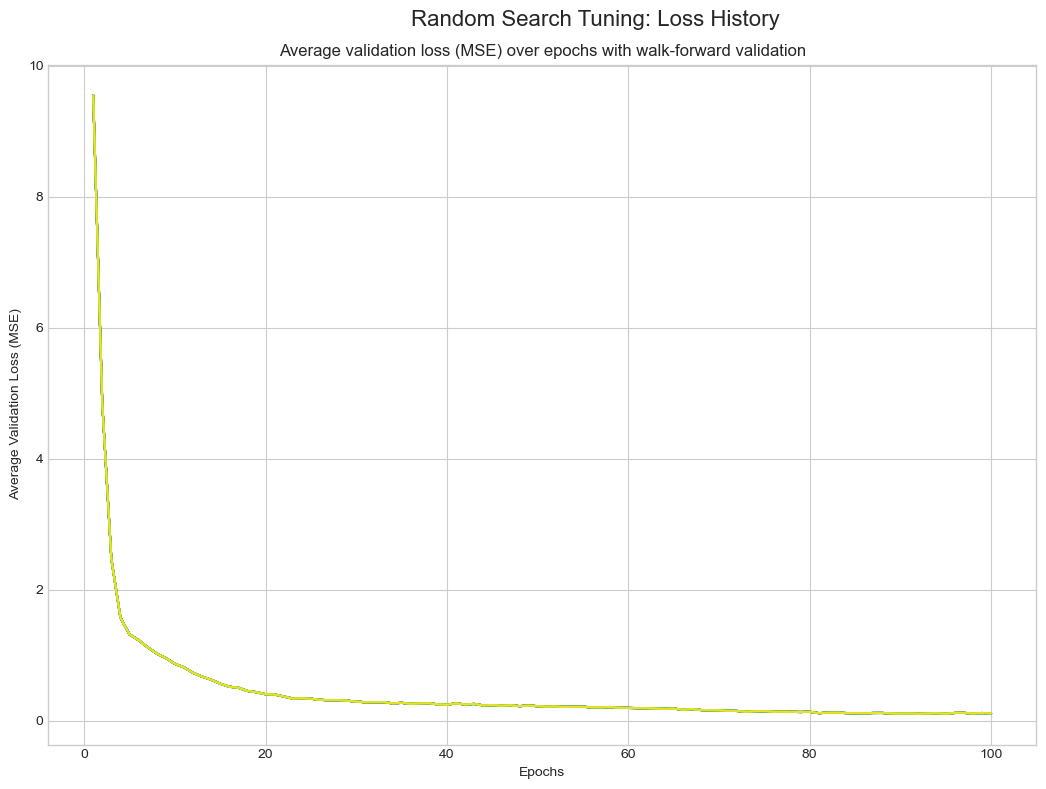

In [53]:
# random - plt
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

all_histories_random = []

for trial in study.trials:
    try:
        trial_histories = trial.user_attrs["all_loss_histories"][0][0][0][2]
       
        if trial_histories and isinstance(trial_histories, list) and isinstance(trial_histories[0], list):
            max_len = max(len(h) for h in trial_histories)
            padded_histories = [np.pad(h, (0, max_len - len(h)), 'edge') for h in trial_histories]
            
            if padded_histories:
                average_history = np.mean(padded_histories, axis=0)
                all_histories_random.append(average_history)

    except (KeyError, IndexError, TypeError) as e:
        print(f"Skipping trial {trial.number} due to data access error: {e}")
        continue

colors = plt.cm.viridis(np.linspace(0, 1, len(all_histories_random))) # type: ignore


for i, history in enumerate(all_histories_random):
    plt.plot(range(1, len(history) + 1), history, color=colors[i], alpha=0.6, label=f'Trial {i+1}')

plt.title('Average validation loss (MSE) over epochs with walk-forward validation')
plt.xlabel('Epochs')
plt.ylabel('Average Validation Loss (MSE)')
plt.grid(True)
plt.suptitle("Random Search Tuning: Loss History", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.88, 1]) # type: ignore
plt.show()

In [ ]:
# cf. ga optimzier

import random
import numpy as np
import matplotlib.pyplot as plt

from src._utils import main_logger


class GeneticAlgorithmOptimizer:
    def __init__(self, search_space, population_size, generations, mutation_rate, crossover_rate):
        self.search_space = search_space
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = []
        self.best_solution = None
        self.best_loss = float('inf')

    def _initialize_population(self):
        for _ in range(self.population_size):
            hparams = {}
            for key, value in self.search_space.items():
                if isinstance(value, tuple) and len(value) == 2:
                    if isinstance(value[0], float) or isinstance(value[1], float):
                        hparams[key] = random.uniform(value[0], value[1])
                    else:
                        hparams[key] = random.randint(value[0], value[1])
                elif isinstance(value, list):
                    hparams[key] = random.choice(value)
            self.population.append(hparams)

    def _crossover(self, parent1, parent2):
        child = {}
        for key in self.search_space:
            child[key] = parent1[key] if random.random() > 0.5 else parent2[key]
        return child

    def _mutate(self, hparams):
        for key, value in self.search_space.items():
            if random.random() < self.mutation_rate:
                if isinstance(value, tuple) and len(value) == 2:
                    if isinstance(value[0], float) or isinstance(value[1], float):
                        hparams[key] = random.uniform(value[0], value[1])
                    else:
                        hparams[key] = random.randint(value[0], value[1])
                elif isinstance(value, list):
                    hparams[key] = random.choice(value)


    def run(self, eval_func, X, y, budget, train_window, val_window):
        self._initialize_population()
        all_evaluated_histories = []

        for generation in range(self.generations):
            main_logger.info(f'... GA Generation {generation + 1}/{self.generations} ...')
            
            evaluated_population = []
            for hparams in self.population:
                loss, history = eval_func(hparams, budget, X, y, train_window, val_window)
                evaluated_population.append({'hparams': hparams, 'loss': loss, 'history': history})
                all_evaluated_histories.append({'hparams': hparams, 'loss': loss, 'history': history})

            evaluated_population.sort(key=lambda x: x['loss'])
            
            current_best_loss = evaluated_population[0]['loss']
            if current_best_loss < self.best_loss:
                self.best_loss = current_best_loss
                self.best_solution = evaluated_population[0]['hparams']

            main_logger.info(f'... ga generation {generation + 1} best loss: {current_best_loss:.4f}')

            next_generation = [evaluated_population[0]['hparams']]
            
            while len(next_generation) < self.population_size:
                parent1 = random.choice(evaluated_population[:self.population_size//2])['hparams']
                parent2 = random.choice(evaluated_population[:self.population_size//2])['hparams']
                
                if random.random() < self.crossover_rate:
                    child = self._crossover(parent1, parent2)
                    self._mutate(child)
                    next_generation.append(child)
                else:
                    next_generation.append(parent1)
            
            self.population = next_generation[:self.population_size]

        return self.best_solution, self.best_loss, all_evaluated_histories


main_logger.info('... starting genetic algorithm optimizer ...')
ga_search_space = {
    'lr': (1e-6, 1e-1),
    'hidden_dim': [16, 32, 64, 128, 256],
    'layer_dim': [1, 2, 3, 4, 5],
    'dropout': (0.1, 0.6),
    'batch_size': [16, 32, 64, 128, 256]
}
ga_optimizer = GeneticAlgorithmOptimizer(
    search_space=ga_search_space,
    population_size=10,
    generations=2,
    mutation_rate=0.1,
    crossover_rate=0.8
)
best_config_ga, best_loss_ga, ga_histories = ga_optimizer.run(
    eval_func=train_and_val_wfv,
    X=X_train,
    y=y_train,
    budget=R,
    train_window=train_window,
    val_window=val_window,
)
main_logger.info(f'... best GA config: {best_config_ga}\n val loss: {best_loss_ga:.4f} ...')


2025-09-08 03:26:10,982 - root - INFO - ... starting genetic algorithm optimizer ...
2025-09-08 03:26:10,983 - root - INFO - ... GA Generation 1/2 ...
2025-09-08 03:26:10,983 - root - INFO - ... running Walk-Forward Validation Fold 1/5...
2025-09-08 03:26:10,983 - root - INFO - ... training on samples 0 to 2999
2025-09-08 03:26:10,984 - root - INFO - ... validating on samples 3000 to 3499
2025-09-08 03:26:10,986 - root - INFO - ... start epoch 1 ...
2025-09-08 03:26:11,089 - root - INFO - ... epoch 1: loss 0.2408 ...
2025-09-08 03:26:11,089 - root - INFO - ... start epoch 2 ...
2025-09-08 03:26:11,179 - root - INFO - ... epoch 2: loss 0.4506 ...
2025-09-08 03:26:11,179 - root - INFO - ... start epoch 3 ...
2025-09-08 03:26:11,269 - root - INFO - ... epoch 3: loss 0.1543 ...
2025-09-08 03:26:11,270 - root - INFO - ... start epoch 4 ...
2025-09-08 03:26:11,360 - root - INFO - ... epoch 4: loss 0.1005 ...
2025-09-08 03:26:11,361 - root - INFO - ... start epoch 5 ...
2025-09-08 03:26:11,45

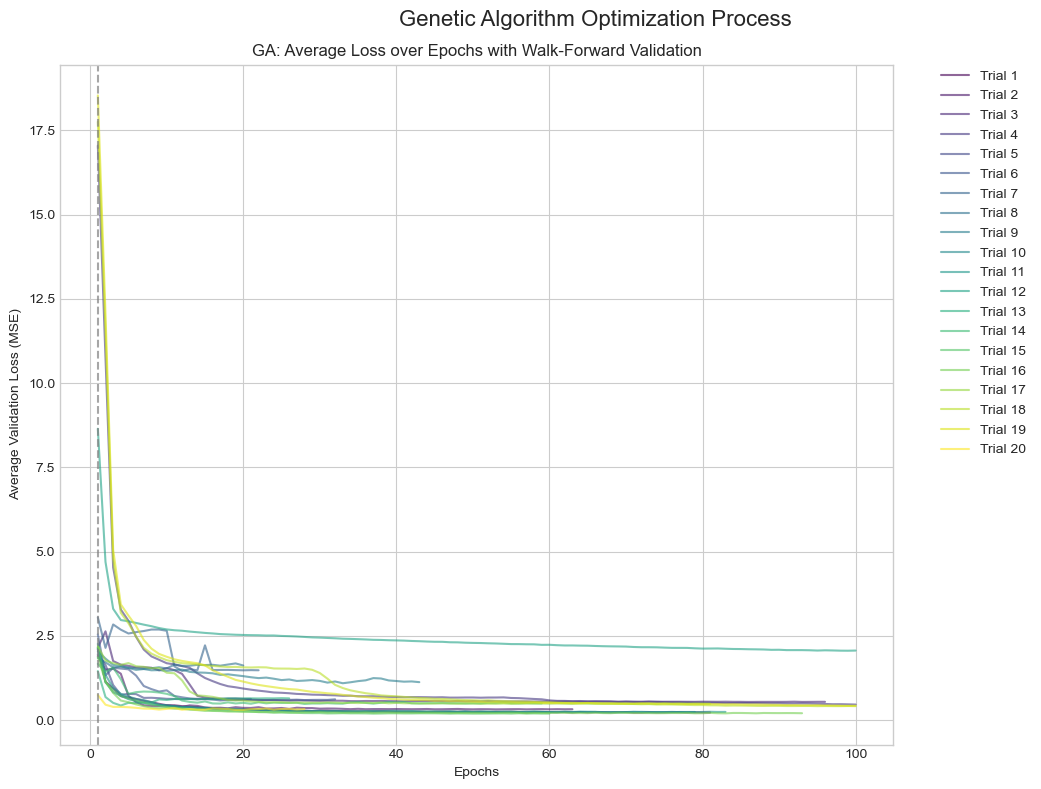

In [ ]:
# ga optimzier plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

all_individual_histories = []
for eval_result in ga_histories:
    list_of_fold_histories = eval_result['history']
    
    if list_of_fold_histories and any(h for h in list_of_fold_histories):
        np_histories = [np.array(h) for h in list_of_fold_histories if h is not None and len(h) > 0]
        if np_histories:
            max_len = max(len(h) for h in np_histories)
            padded_np_histories = [np.pad(h, (0, max_len - len(h)), 'edge') for h in np_histories]
            average_history_for_config = np.mean(padded_np_histories, axis=0)
            all_individual_histories.append(average_history_for_config)

colors = plt.cm.viridis(np.linspace(0, 1, len(all_individual_histories)))

for i, history in enumerate(all_individual_histories):
    plt.plot(range(1, len(history) + 1), history, color=colors[i], alpha=0.6, label=f'Trial {i+1}')

plt.title('GA: Average Loss over Epochs with Walk-Forward Validation')
plt.xlabel('Epochs')
plt.ylabel('Average Validation Loss (MSE)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.suptitle("Genetic Algorithm Optimization Process", fontsize=16)

plt.axvline(x=budget, linestyle='--', color='gray', alpha=0.7)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()
